In [1]:
%matplotlib inline
import numpy as np
# Print with smaller accurary to make comparisons easier
np.set_printoptions(precision=7, suppress=True)

import matplotlib.pyplot as plt


# Discretization
The discretization follows the first multi-grid worksheet completely.
We discretize
$$ \begin{array}{r c l}
-\cfrac{d^2 u}{d x^2}&=&f(x),~~~x\in(0,1),\\
u(0)=u(1) & = & 0.
\end{array}
$$
on a grid with $h=1/N$ and $N+1$ grid points.

Let's define a grid first.

In [2]:
class Grid(object):
    def __init__(self, num_points):
        # Num points does not include boundary!
        self.num_points = num_points
        self.spacing = 1.0/(num_points + 1)
        
    def get_nth_point(self, i):
        return self.spacing * (i + 1)
        

def make_grid(level):
    # Level is refinement
    # Consider interval [0,1]
    # Level one has one point at 1/2
    # Level two has points at 1/4, 1/2, 3/4
    num_points = 2**(level + 1) - 1
    return Grid(num_points)


grid = make_grid(level=2)
grid.get_nth_point(1)

0.25

We use a finite difference discretization and eliminate all rows corresponding to the Dirichlet boundary conditions.
For more details, see the worksheet.
The matrix then looks like:
$$A_{ij}:=\left\{\begin{array}{r c l}
-\frac{1}{h^2} & \hbox{if} & |i-j|=1,\\
\frac{2}{h^2} & \hbox{if} & i=j,\\
0 & \hbox{otherwise},\end{array}\right.
$$

In [3]:
def create_matrix(grid):
    n = grid.num_points
    h = grid.spacing
    
    def val(i,j):
        if i == j:
            return 2/h**2
        elif np.abs(i-j) == 1:
            return -1/h**2
        else:
            return 0.0
        
    return np.fromfunction(np.vectorize(val), (n, n), dtype=float)


discretization = create_matrix(grid)
discretization


array([[128., -64.,   0.,   0.,   0.,   0.,   0.],
       [-64., 128., -64.,   0.,   0.,   0.,   0.],
       [  0., -64., 128., -64.,   0.,   0.,   0.],
       [  0.,   0., -64., 128., -64.,   0.,   0.],
       [  0.,   0.,   0., -64., 128., -64.,   0.],
       [  0.,   0.,   0.,   0., -64., 128., -64.],
       [  0.,   0.,   0.,   0.,   0., -64., 128.]])

# Restriction by injection
We use restriction by injection.
The restriction operator maps from a fine grid solution (size: in_dim) to a coarse grid solution (size: out_dim).
It does this by using the fact that fine and coarse grid solution have shared nodes. The solution at these shared nodes is taken as solution for the coarse grid.
See lecture for more details

In [4]:
# %load solution_injection.py
def injection_matrix(in_dim, out_dim):
    # TODO Implement
    def val(i,j):
        i = i + 1
        j = j + 1
        if 2*i ==  j:
            return 1
        else:
            return 0
        
    return np.fromfunction(np.vectorize(val), (in_dim, out_dim), dtype=float)

injection_matrix(3, 7)

array([[0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0]])

# Linear Interpolation
We use the linear interpolation scheme, defined by
$$
(P q^m_{2_h})_i = 
\begin{cases}
(q^m_{2h})_{i/2}
& 
\text{for } i = 2, 4, \ldots, N -2
\\
\frac{1}{2} \left( 
(q^m_{2h})_{(i-1)/2} + (q^m_{2h})_{(i+1)/2}
\right)
& 
\text{for } i = 1, 3, \ldots, N - 1
\end{cases}
$$

In [5]:
# %load solution_interpolation.py
def interpolation_matrix(in_dim, out_dim):
    def val(i,j):
        i = i + 1
        j = j + 1
        if i % 2 == 0 and j == i//2:
            return 1.0
        elif i % 2 == 1 and (j == (i+1)//2 or j == (i-1)//2):
            return 0.5
        return 0.0
                
    return np.fromfunction(np.vectorize(val), (in_dim, out_dim), dtype=float)


interpolation_matrix(7, 3)


array([[0.5, 0. , 0. ],
       [1. , 0. , 0. ],
       [0.5, 0.5, 0. ],
       [0. , 1. , 0. ],
       [0. , 0.5, 0.5],
       [0. , 0. , 1. ],
       [0. , 0. , 0.5]])

# 2 Step MG Scheme

In [6]:
def jacobi_relaxation(A, x, b, num_it, omega=2.0/3.0):
    diagonal_part = np.diag(A.diagonal())
    diagonal_part_inv = np.diag(1/A.diagonal())
    rest = A - diagonal_part
    for i in range(num_it):
        x = omega * (diagonal_part_inv @ (b - rest @ x)) + (1.0 - omega) * x
    return x

In [7]:
  
class Multigrid(object):
    def __init__(self, level_coarse, omega, u_0, f, jacobi_its=40):
        self.omega = omega
        self.level_coarse = level_coarse
        self.level_fine = level_coarse + 1

        self.grid_coarse = make_grid(level=self.level_coarse)
        self.grid_fine = make_grid(level=self.level_fine)

        self.u_0 = u_0
        self.f = f

        self.jacobi_its = jacobi_its
        
        # Setup fine grid
        self.discretization_fine = create_matrix(self.grid_fine)

        # Projection
        self.R = injection_matrix(self.grid_coarse.num_points, self.grid_fine.num_points)
        self.P = interpolation_matrix(self.grid_fine.num_points, self.grid_coarse.num_points)
        
        # Setup coarse grid
        self.discretization_coarse = (
           self.R @ self.discretization_fine @ self.P)
        self.discretization_coarse = create_matrix(self.grid_coarse)

        # Solve linear system (for comparison)
        self.u_direct = np.linalg.solve(
            self.discretization_fine,
            self.f)

        self.u = u_0
    
    def step(self):
        # Pre-smoothing
        self.u = jacobi_relaxation(self.discretization_fine, self.u, self.f, 
                                      num_it=self.jacobi_its,
                                      omega=self.omega)

        self.residual = self.f - self.discretization_fine @ self.u

        self.residual_coarse = self.R @ self.residual

        # Solve exactly on coarse grid
        self.error_coarse = np.linalg.solve(self.discretization_coarse, self.residual_coarse)
        
        # Project error to fine grid
        self.error_fine = self.P @ self.error_coarse

        self.u += self.error_fine
        
        # Post smoothing
        self.u = jacobi_relaxation(self.discretization_fine, self.u, self.f, 
                                    num_it=self.jacobi_its,
                                    omega=self.omega)

    def compute_error(self):
        return np.linalg.norm(self.u - self.u_direct)
    
level_coarse = 5
grid_fine = make_grid(level=level_coarse+1)
f = np.ones(grid_fine.num_points) * 10
u_0 = np.zeros(grid_fine.num_points)
    
mg = Multigrid(level_coarse=level_coarse,
               omega=1/2,
               u_0=u_0,
               f=f,
               jacobi_its=2)

# Record for plotting
errors_mg = []

prev_error = mg.compute_error()
residuals_mg = []
print(f"Initial error: {prev_error}")
for it in range(10):
    mg.step()
    error = mg.compute_error()
    print("Error at it", it, "=", error)
    print("\tcompared to prev error reduced by\t", prev_error - error)
    prev_error = error
    
    errors_mg += [error]
    residuals_mg += [np.linalg.norm(mg.residual)]

Initial error: 10.327955570649042
Error at it 0 = 1.0662402999395435e-05
	compared to prev error reduced by	 10.327944908246042
Error at it 1 = 7.285776441962125e-07
	compared to prev error reduced by	 9.933825355199222e-06
Error at it 2 = 3.0555383789778395e-08
	compared to prev error reduced by	 6.980222604064341e-07
Error at it 3 = 2.0230543909061808e-09
	compared to prev error reduced by	 2.8532329398872215e-08
Error at it 4 = 1.043630194718287e-10
	compared to prev error reduced by	 1.918691371434352e-09
Error at it 5 = 6.789850457277317e-12
	compared to prev error reduced by	 9.757316901455138e-11
Error at it 6 = 4.201720666340541e-13
	compared to prev error reduced by	 6.369678390643263e-12
Error at it 7 = 5.436503555804347e-13
	compared to prev error reduced by	 -1.2347828894638055e-13
Error at it 8 = 7.501007487170766e-13
	compared to prev error reduced by	 -2.0645039313664196e-13
Error at it 9 = 5.127489085124402e-13
	compared to prev error reduced by	 2.373518402046364e-13


In [8]:
# Compare with Jacobi only:
u_jacobi = u_0
prev_error_jacobi = np.linalg.norm(u_jacobi - mg.u_direct)
print(f"Initial error: {prev_error_jacobi}")
errors_jacobi = []
residuals_jacobi = []
for it in range(10):
    u_jacobi = jacobi_relaxation(mg.discretization_fine, u_jacobi, f, num_it=1, omega=2/3)
    error = np.linalg.norm(u_jacobi - mg.u_direct)
    errors_jacobi.append(error)
    residual = np.linalg.norm(f - mg.discretization_fine @ u_jacobi)
    residuals_jacobi.append(residual)
    print("Error at it", it, "=", error)
    print("\tcompared to prev error reduced by\t", prev_error_jacobi - error)



Initial error: 10.327955570649042
Error at it 0 = 10.32585451173009
	compared to prev error reduced by	 0.002101058918951182
Error at it 1 = 10.32375403869862
	compared to prev error reduced by	 0.004201531950421611
Error at it 2 = 10.321654145030593
	compared to prev error reduced by	 0.0063014256184494855
Error at it 3 = 10.319554826144284
	compared to prev error reduced by	 0.00840074450475825
Error at it 4 = 10.31745607829982
	compared to prev error reduced by	 0.010499492349222095
Error at it 5 = 10.315357898270515
	compared to prev error reduced by	 0.012597672378527491
Error at it 6 = 10.313260283185649
	compared to prev error reduced by	 0.014695287463393214
Error at it 7 = 10.311163230440306
	compared to prev error reduced by	 0.016792340208736434
Error at it 8 = 10.309066737637846
	compared to prev error reduced by	 0.018888833011196482
Error at it 9 = 10.306970802550522
	compared to prev error reduced by	 0.020984768098520235


Text(0, 0.5, 'Residual')

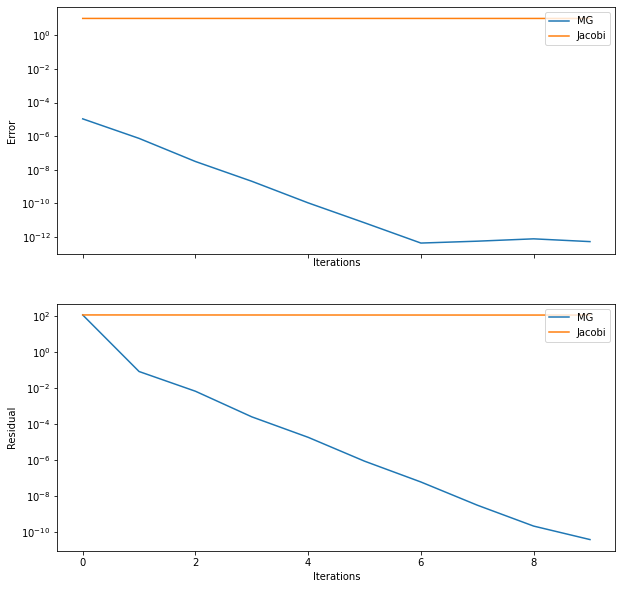

In [9]:
fig, axs = plt.subplots(2, figsize=(10, 10), sharex=True)
x = range(0, len(errors_mg))
axs[0].semilogy(x, errors_mg, label="MG")
axs[1].semilogy(x, residuals_mg, label="MG")

x = range(0, len(errors_jacobi))
axs[0].semilogy(x, errors_jacobi, label="Jacobi")
axs[1].semilogy(x, residuals_jacobi, label="Jacobi")

for ax in axs:
    ax.legend(loc="upper right")
    ax.set_xlabel("Iterations")


axs[0].set_ylabel("Error")
axs[1].set_ylabel("Residual")